# Test JulES

### Import packages

In [13]:
using Pkg; Pkg.status()
Pkg.add("CSV"); Pkg.add("Revise"); Pkg.add("Plots"); Pkg.add("PlotlyJS"); Pkg.add("PrettyTables")
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"TuLiPa")); Pkg.status() # go to development version
# Pkg.undo(); Pkg.status() # go back to main package version
# Pkg.add(url="https://github.com/NVE/TuLiPa.git"); Pkg.status() # alternative go back to latest version

In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, CSV, Plots, PrettyTables
# plotlyjs(); # uncomment for interactive plots

In [3]:
# config = YAML.load_file(joinpath("data", "config_jules_la.yml")) # config without datasets
config = YAML.load_file(joinpath(dirname(dirname(pwd())), "JulESIO", "config_jules_la_demo.yml")) # config with NVE datasets
scenarioyear = config["main"]["weatheryears"][1]
datayear = config["main"]["datayears"][1];

### Prepare parallell processing - import code on all cores

In [4]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 31


In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(dirname(pwd()))),"jgrc/TuLiPa/src/TuLiPa.jl"));

In [6]:
@everywhere using JulES
# @everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

In [7]:
function getdataset(config, scenarioyear)
    settings = config[config["main"]["settings"]]

    sti_thema = joinpath(config["main"]["inputpath"], "datasett", "data_fra_thema")
    sti_vannkraft = joinpath(config["main"]["inputpath"], "datasett", "data_fra_dynmodell")

    tsd = JSON.parsefile(joinpath(sti_thema, "dataset_thema.json"))
    themastructure = JulES.getelements(tsd, sti_thema)
    tst = JSON.parsefile(joinpath(sti_thema, "dataset_thema_excl_hydro_nose.json"))
    themastructure_exl = JulES.getelements(tst, sti_thema)
    tse = JSON.parsefile(joinpath(sti_thema, "tidsserier_thema.json"))
    themaseries = JulES.getelements(tse, sti_thema)

    dse = JSON.parsefile(joinpath(sti_vannkraft, "tidsserier_detd.json"))
    detdseries = JulES.getelements(dse)
    dst = JSON.parsefile(joinpath(sti_vannkraft, "dataset_detd.json"))
    detdstructure = JulES.getelements(dst)

    progelements = vcat(themaseries, themastructure)
    
    if JulES.getonlyagghydro(settings)
        global detailedrescopl = Dict()
        return Dict("elements" => progelements, "detailedrescopl" => detailedrescopl)
    else
        global elements = vcat(themaseries, themastructure_exl, detdseries, detdstructure)
        global detailedrescopl = JSON.parsefile(joinpath(sti_vannkraft, "magasin_elspot.json"))
        return Dict("elements" => elements, "progelements" => progelements, "detailedrescopl" => detailedrescopl)
    end
end

dataset = getdataset(config, scenarioyear)

Dict{String, Any} with 3 entries:
  "progelements"    => DataElement[DataElement("TimeDelta", "MsTimeDelta", "Hou…
  "elements"        => DataElement[DataElement("TimeDelta", "MsTimeDelta", "Hou…
  "detailedrescopl" => Dict{String, Any}("49925"=>"NO3", "62801"=>"NO4", "16655…

In [8]:
data = JulES.run_serial(config, datayear, scenarioyear, dataset)

Time parameters
  0.036904 seconds (1.44 k allocations: 93.798 KiB, 99.33% compilation time)
Get data
  0.001540 seconds (20 allocations: 2.690 MiB)
Make dummy objects


  6.884264 seconds (11.24 M allocations: 2.055 GiB, 15.94% gc time, 44.96% compilation time)
Init scenario modelling for simulation, prognosis and stochastic


  3.642810 seconds (2.54 M allocations: 66.492 MiB, 93.56% compilation time)
  3.685144 seconds (2.54 M allocations: 66.859 MiB, 93.62% compilation time)
Init prognosis

 61.712658 seconds (4.64 M allocations: 215.045 MiB, 1.61% compilation time)

 66.861706 seconds (7.40 M allocations: 436.327 MiB, 0.16% gc time, 6.49% compilation time: <1% of which was recompilation)
Mapping between aggregated and detailed storages


 16.819042 seconds (823.33 k allocations: 89.668 MiB, 3.69% compilation time)
Init stochastic


  3.730928 seconds (10.06 M allocations: 458.357 MiB, 2.75% gc time, 37.19% compilation time)


  2.664175 seconds (9.66 M allocations: 436.396 MiB, 5.48% gc time, 8.52% compilation time)


  9.032210 seconds (2.28 M allocations: 68.188 MiB, 2.51% compilation time)


  2.315605 seconds (1.92 M allocations: 245.510 MiB, 18.20% gc time, 42.53% compilation time)
 23.171156 seconds (29.50 M allocations: 2.298 GiB, 4.38% gc time, 21.50% compilation time)
Init clearing

  0.522457 seconds (322.05 k allocations: 97.409 MiB, 43.82% compilation time)

  0.524171 seconds (273.02 k allocations: 15.745 MiB, 66.23% compilation time)


  9.586445 seconds (10.63 M allocations: 1.961 GiB, 12.90% gc time, 34.69% compilation time)


 11.039480 seconds (11.43 M allocations: 2.084 GiB, 11.20% gc time, 38.86% compilation time)
Init results


  2.318651 seconds (1.42 M allocations: 92.133 MiB, 90.79% compilation time)


Simulate forward
FixedDataTwoTime(

DateTime("2024-12-30T00:00:00"), DateTime("1980-12-31T00:00:00"))


  0.238909 seconds (1.99 M allocations: 36.633 MiB)


  3.617794 seconds (262.62 k allocations: 15.411 MiB, 2.75% compilation time)


  2.383667 seconds (2.27 M allocations: 75.217 MiB, 5.33% compilation time)


  3.052625 seconds (632.79 k allocations: 32.663 MiB, 2.37% compilation time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-02T00:00:00"))


  2.369683 seconds (138.23 k allocations: 7.009 MiB)


  0.714449 seconds (2.09 M allocations: 55.544 MiB)


  3.147548 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-04T00:00:00"))


  2.400707 seconds (138.22 k allocations: 7.006 MiB)


  0.804565 seconds (2.09 M allocations: 55.541 MiB)


  3.033959 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-06T00:00:00"))


  3.289895 seconds (138.18 k allocations: 7.007 MiB)


  1.595958 seconds (2.09 M allocations: 55.537 MiB)


  2.522968 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-08T00:00:00"))


  0.241489 seconds (1.99 M allocations: 36.633 MiB)


  1.973727 seconds (138.20 k allocations: 7.005 MiB)


  0.714078 seconds (2.09 M allocations: 55.541 MiB)


  2.380953 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-10T00:00:00"))


  2.020524 seconds (138.21 k allocations: 7.006 MiB)


  0.743566 seconds (2.09 M allocations: 55.552 MiB)


  2.327728 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-12T00:00:00"))


  2.341809 seconds (138.21 k allocations: 7.005 MiB)


  0.715002 seconds (2.09 M allocations: 55.538 MiB)


  2.673692 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-14T00:00:00"))


  3.552431 seconds (138.19 k allocations: 7.006 MiB)


  1.762530 seconds (2.09 M allocations: 55.535 MiB)


  2.989910 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-16T00:00:00"))


  0.228390 seconds (1.99 M allocations: 36.634 MiB)


  2.740109 seconds (138.22 k allocations: 7.004 MiB)


  0.753269 seconds (2.09 M allocations: 55.538 MiB)


  3.233268 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-18T00:00:00"))


  2.525587 seconds (138.22 k allocations: 7.007 MiB)


  0.711598 seconds (2.09 M allocations: 55.533 MiB)


  2.419058 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-20T00:00:00"))


  2.504288 seconds (138.21 k allocations: 7.005 MiB)


  0.700183 seconds (2.09 M allocations: 55.540 MiB)


  2.427811 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-22T00:00:00"))


  3.556003 seconds (138.19 k allocations: 7.006 MiB)


  1.793807 seconds (2.09 M allocations: 55.538 MiB)


  2.798967 seconds (622.92 k allocations: 32.039 MiB, 9.62% gc time)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-24T00:00:00"))


  0.229342 seconds (1.99 M allocations: 36.633 MiB)


  2.598452 seconds (138.21 k allocations: 7.004 MiB)


  0.696832 seconds (2.09 M allocations: 55.540 MiB)


  2.502628 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-26T00:00:00"))


  2.083096 seconds (138.23 k allocations: 7.007 MiB)


  0.713441 seconds (2.09 M allocations: 55.541 MiB)


  2.754857 seconds (621.47 k allocations: 31.893 MiB)
FixedDataTwoTime(DateTime("2024-12-30T00:00:00"), DateTime("1981-01-28T00:00:00"))


  1.871188 seconds (138.23 k allocations: 7.008 MiB)


  0.722880 seconds (2.09 M allocations: 55.541 MiB)


  2.672865 seconds (621.47 k allocations: 31.893 MiB)
The simulation took: 1.8198816816666665 minutes
Time usage per timestep: 6.82455630625 seconds
Handle output


Row,model,update,solve,other,total
,String,Float64,Float64,Float64,Float64
1,long,0.15594,0.114455,0.000134855,0.27053
2,med,0.261234,0.174346,0.0898561,0.525437
3,short,0.200885,1.89604,0.0357623,2.13269
4,clearing,0.0521486,2.57666,0.0979766,2.72678


Row,umaster,usub,conv,count,smaster,ssub,hlmaster,wwres,total,short,core
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Int64
1,0.0002988,0.0223537,0.304124,1.6,0.00291011,0.299685,3.33333e-6,0.00023664,0.363285,false,11
2,0.000289307,0.0246657,0.279799,1.6,0.00209187,0.276447,3.06667e-6,0.000175227,0.34337,false,12
3,0.000324347,0.0340143,0.266121,1.6,0.00261043,0.262105,3.01333e-6,0.000191147,0.339737,false,16
4,0.000327147,0.0195545,0.266032,1.6,0.00197917,0.262585,2.4e-6,0.000179867,0.324368,false,17
5,0.0001431,0.0207002,0.265527,0.4,0.00109979,0.263774,4.8e-7,7.77467e-5,0.295375,true,4
6,0.000361173,0.0289691,0.212209,1.6,0.0021624,0.208397,2.72e-6,0.00024032,0.279219,false,10
7,0.000221533,0.0206018,0.24491,0.466667,0.00157315,0.242615,6.8e-7,7.68333e-5,0.274831,true,2
8,0.000316213,0.0294135,0.194783,1.6,0.00195083,0.191667,3.52e-6,0.00012032,0.273936,false,20
9,0.000273653,0.024294,0.18423,1.6,0.0018708,0.181427,2.61333e-6,0.000110267,0.252325,false,14


Row,core,umaster_sum,usub_sum,conv_sum,count_sum,smaster_sum,ssub_sum,hlmaster_sum,wwres_sum,total_sum
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,11,0.00229485,0.110188,0.450658,30.6667,0.0172769,0.420632,6.096e-5,0.00068392,0.671016
2,12,0.00253139,0.0873132,0.446708,29.6,0.0157497,0.418229,6.94133e-5,0.000691787,0.640446
3,16,0.00241296,0.0831736,0.400495,30.9333,0.0171233,0.371112,6.176e-5,0.000646987,0.584972
4,10,0.00263939,0.0873419,0.37075,32.8,0.0182534,0.338485,6.496e-5,0.000716267,0.574404
5,17,0.00229776,0.0689305,0.404936,26.1333,0.0142435,0.379261,4.97867e-5,0.00061664,0.569457
6,14,0.0183829,0.0745973,0.331189,30.6667,0.0162331,0.302964,6.176e-5,0.00058272,0.534018
7,13,0.00244787,0.0763556,0.321841,31.2,0.0177183,0.289483,5.808e-5,0.000589333,0.505416
8,20,0.00196925,0.0715622,0.301158,23.2,0.0117316,0.278678,5.99733e-5,0.000483147,0.47877
9,22,0.00191712,0.0913911,0.259572,21.6,0.0135583,0.235085,5.6e-5,0.000537627,0.460201


9-element Vector{Float64}:
  0.0021353262222222223
  0.060965964888888884
  0.24846687022222216
 20.035555555555558
  0.010404101777777779
  0.22883130511111108
  4.2218222222222226e-5
  0.00042859044444444437
  0.3936136224444444

 20.359800 seconds (11.92 M allocations: 859.902 MiB, 1.19% gc time, 56.86% compilation time: 6% of which was recompilation)


Dict{Any, Any} with 27 entries:
  "svindex"            => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "demandbalancenames" => SubString{String}["NO2", "NO2", "NO2", "NO2", "NO2", …
  "skipfactor"         => 4.0
  "stochastictimes"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … …
  "resindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "areanames"          => ["NO2"]
  "priceindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-2…
  "batmatrix"          => [0.0585 0.0795 0.0; 0.117 0.159 0.0; … ; 0.117 0.159 …
  "stateindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "statematrix"        => [1.615 14.1 … 0.75 54.3287; 1.615 14.1 … 0.75 57.1289…
  "statenames"         => ["Reservoir_2801", "Reservoir_26609_max", "Reservoir_…
  "resnames"           => ["Reservoir_13504", "Reservoir_13801", "Reservoir_789…
  "shorts"             => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, …
  "demandvalu

In [9]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = data["statematrix"]
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"];

storagevalues = data["storagevalues"]
storagenames = data["storagenames"]
scenarionames = data["scenarionames"]
shorts = data["shorts"]
skipfactor = data["skipfactor"];

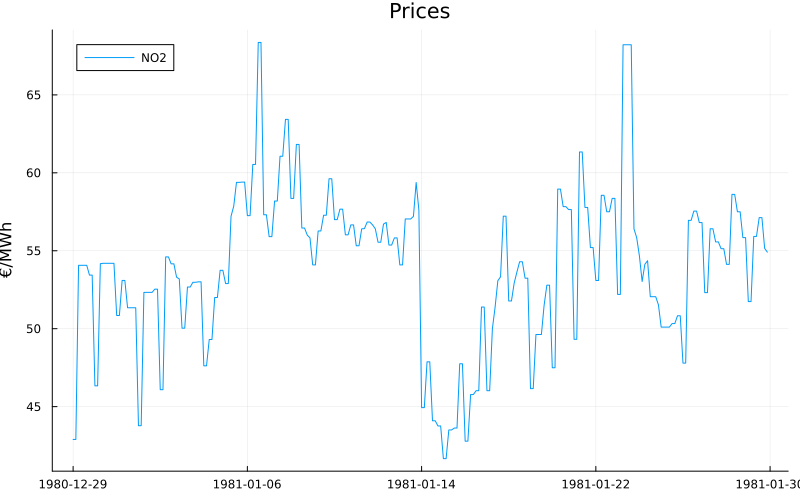

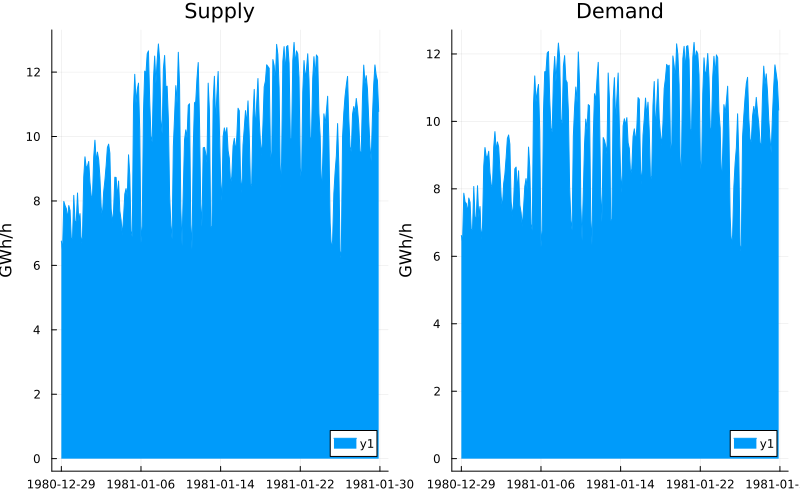

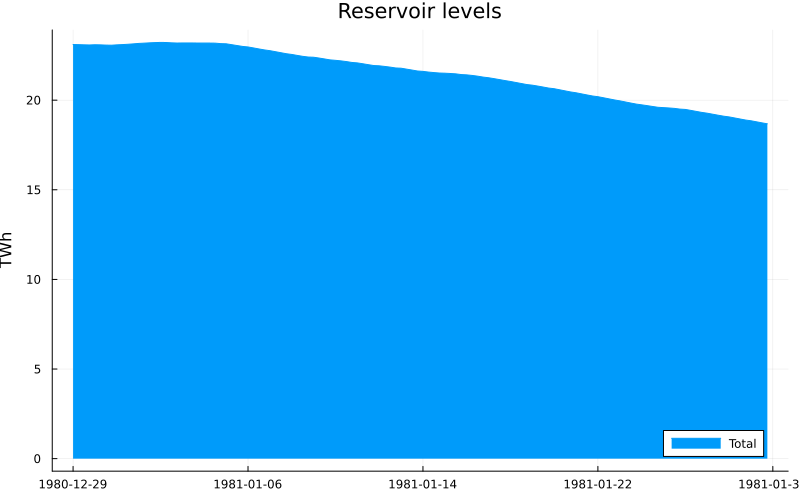

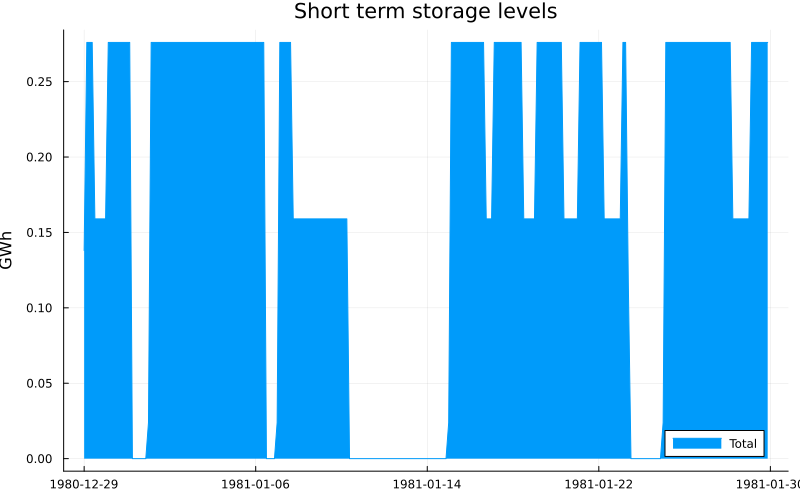

┌───────────────────────────────────┬───────────────────────────────────┐
│ Yearly_supply_TWh_sum_skipmissing │ Yearly_demand_TWh_sum_skipmissing │
├───────────────────────────────────┼───────────────────────────────────┤
│                           87.2493 │                           84.6372 │
└───────────────────────────────────┴───────────────────────────────────┘


In [10]:
# Plot prices
idxwohub = findall(x -> !occursin("HUB", x), powerbalancenames) # remove hubs, not active in 2025 dataset
display(plot(x1, prices[:,idxwohub]*100, labels=reshape(powerbalancenames[idxwohub],1,length(powerbalancenames[idxwohub])), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
# maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
# supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
# demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
sumsupplyvalues = sum(supplyvalues,dims=2)
sumdemandvalues = sum(demandvalues,dims=2)
maxdemsup = isempty(sumsupplyvalues) ? maximum(sumdemandvalues) : (isempty(sumdemandvalues) ? maximum(sumsupplyvalues) : max(maximum(sumdemandvalues), maximum(sumsupplyvalues)))
supplychart = areaplot(x1,sumsupplyvalues,title="Supply", ylabel = "GWh/h")
demandchart = areaplot(x1,sumdemandvalues,title="Demand", ylabel = "GWh/h")
display(plot([supplychart,demandchart]...,layout=(1,2),size=(800,500)))

# Plot storages
# display(areaplot(x2, hydrolevels,labels=reshape(hydronames,1,length(hydronames)),size=(800,500),title="Reservoir levels", ylabel = "TWh")) #
display(areaplot(x2, dropdims(sum(hydrolevels,dims=2),dims=2),labels="Total",size=(800,500),title="Reservoir levels", ylabel = "TWh")) #

display(areaplot(x1, dropdims(sum(batterylevels,dims=2),dims=2),labels="Total",size=(800,500),title="Short term storage levels", ylabel = "GWh")) #

# Plot list of yearly mean production and demand for each supply/demand TODO: split demand/supply and transmission
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
# show(joineddf,allcols=true, allrows=true, nosubheader = true)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader = false)

# # Plot list of yearly income and cost for each supply/demand (only works if exogenprices are collected)
# supplyrev = copy(supplyvalues)
# for (i,supplybalancename) in enumerate(supplybalancenames)
#     idx = findfirst(isequal(supplybalancename), powerbalancenames)
#     supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
# end
# demandrev = copy(demandvalues)
# for (i,demandbalancename) in enumerate(demandbalancenames)
#     idx = findfirst(isequal(demandbalancename), powerbalancenames)
#     demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
# end
# meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
# meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
# supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
# demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
# supplyrevdf[!,:ID] = collect(1:length(supplynames))
# demandrevdf[!,:ID] = collect(1:length(demandnames))
# joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
# # pretty_table(joinedrevdf,show_subheader = false)

# # Sum revenues and cost
# pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader = false)

# # Plot storagevalues for each reservoir and scenarios
# maxlongtermstorages = 10
# maxshorttermstorages = 10
# shortindex = x3
# medindex = x3[1:Int(skipfactor):Int(end-skipfactor)]
# numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
# numscen = length(scenarionames) - numop
# j = 0
# k = 0
# for (i, storagename) in enumerate(storagenames)
#     if shorts[i]
#         j += 1
#         j > maxshorttermstorages && continue
#         storagevalues_ = storagevalues[:,:,:]
#         index = shortindex
#     else
#         k += 1
#         k > maxlongtermstorages && continue
#         storagevalues_ = storagevalues[1:Int(skipfactor):Int(end-skipfactor),:,:]
#         index = medindex
#     end
#     p = plot(index, storagevalues_[:,1:numscen,i] * -100, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numscen], 1, numscen), ylabel="€/MWh")
#     plot!(p, index, storagevalues_[:,numscen+1:end,i] * -100, labels=reshape(scenarionames[numscen+1:end], 1, numop), linewidth=5)
#     display(p)
# end